_Copyright Notice_

This notebook is available for educational purposes. You may not use or distribute this notebook for commercial purposes. You may make copies of this notebook and use or distribute it for educational purposes as long as you cite the author as the source of the notebook.

Jaeyoung Chun | School of Applied Artificial Intelligence | Handong Global University

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pneumonia Detection using Chest X-Ray Images

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch import optim
import time
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
torch.__version__

'2.0.1+cu118'

In [4]:
%config InlineBackend.figure_format='retina'

In [5]:
# set the random seed
torch.manual_seed(316)

## Download Dataset

We will be using the chest X-ray dataset from this paper:

- Paper: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
- Data: https://data.mendeley.com/datasets/rscbjbr9sj/2?__hstc=25856994.150d33b6a0406ddaab26cc895a6ab69c.1673254521351.1673254521351.1673254521351.1&__hssc=25856994.2.1673254521351&__hsfp=2670138296

In [6]:
!wget -O dataset.zip https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded

--2023-08-07 00:47:17--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2023-08-07 00:47:18--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.92.35.114, 3.5.68.159, 3.5.69.16, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.92.35.114|:443... c

In [7]:
!unzip -q -o dataset.zip

In [8]:
!apt-get install -y tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (341 kB/s)
Selecting previously unselected package tree.
(Reading database ... 120500 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [9]:
!tree chest_xray -L 2

chest_xray
├── test
│   ├── NORMAL
│   └── PNEUMONIA
└── train
    ├── NORMAL
    └── PNEUMONIA

6 directories, 0 files


In [10]:
img_mean = (0.485, 0.456, 0.406)
img_std = (0.229, 0.224, 0.225)

transform_train = transforms.Compose(
    [
        transforms.Resize(size=(256, 256)),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(img_mean, img_std)
    ]
)

transform_val = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(img_mean, img_std)
    ]
)

transform_test = transform_val

In [11]:
PATH_DATA_ROOT = "chest_xray"

In [12]:
# dataset will be split into trainset and valset later
dataset = datasets.ImageFolder(os.path.join(PATH_DATA_ROOT, "train"), transform=transform_train)
testset = datasets.ImageFolder(os.path.join(PATH_DATA_ROOT, "test"), transform=transform_val)

In [13]:
dataset.classes

['NORMAL', 'PNEUMONIA']

In [14]:
dataset.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

In [15]:
idx_to_class = { v:k for k, v in dataset.class_to_idx.items() }
idx_to_class

{0: 'NORMAL', 1: 'PNEUMONIA'}

## Split Data

In [16]:
# split
len_trainset = int(len(dataset) * 0.8)
len_valset = len(dataset) - len_trainset

trainset, valset = torch.utils.data.random_split(dataset, [len_trainset, len_valset])

In [17]:
len(trainset)

4185

In [18]:
len(valset)

1047

In [19]:
len(testset)

624

## Load Dataset

In [20]:
batch_size = 8

In [21]:
# data loader for the training set
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

In [22]:
# data loader for the validatoin set
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=True
)

In [23]:
# data loader for the validatoin set
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=True
)

## Explore

In [24]:
# get a first batch
images, labels = next(iter(trainloader))

In [25]:
images.shape

torch.Size([8, 3, 224, 224])

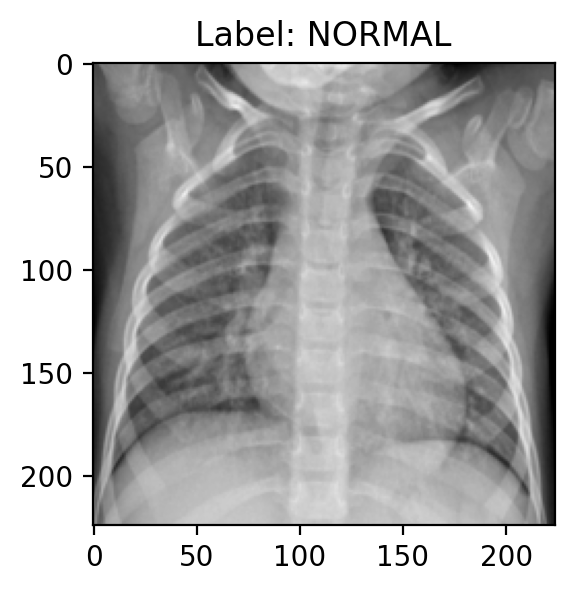

In [26]:
fig, ax = plt.subplots(figsize=(3,3))

img_idx = 0
label = idx_to_class[int(labels[0])]

img = images[img_idx].permute(1, 2, 0) * torch.tensor(img_std) + torch.tensor(img_mean)
ax.imshow(img, cmap="gray")
ax.set_title(f"Label: {label}")

plt.show()

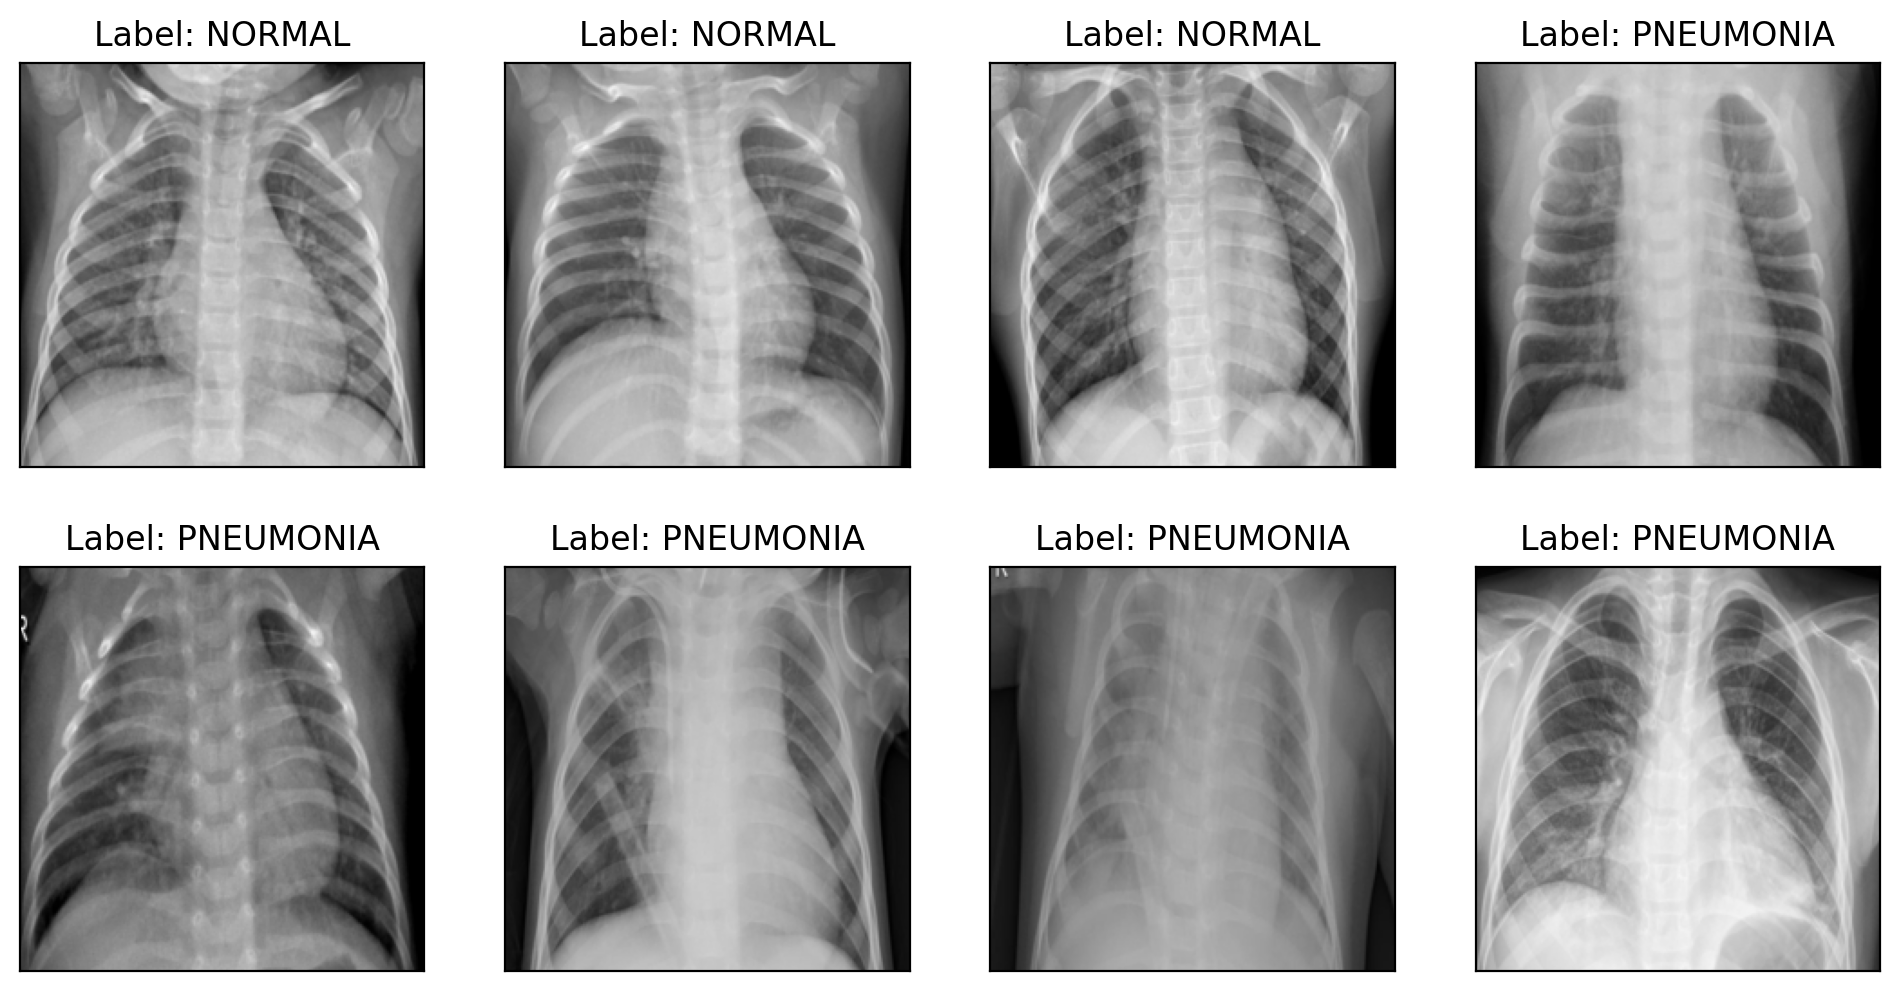

In [27]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(12,6))
ax = np.ravel(ax)

for index in range(8):
    img = images[index].permute(1, 2, 0) * torch.tensor(img_std) + torch.tensor(img_mean)
    ax[index].imshow(img, cmap="gray")
    label = idx_to_class[int(labels[index])]
    ax[index].set_title(f"Label: {label}")
    ax[index].set_xticks([])
    ax[index].set_yticks([])

plt.show()


## Build a Network

In [36]:
class Network(nn.Module):

    def __init__(self):
        super().__init__()

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # stride=kernel_size by default
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 112 * 112, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        out1 = self.feature_extraction(x)
        out2 = torch.flatten(out1, 1)
        out3 = self.classifier(out2)

        return out3


model = Network()

print(model)

Network(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=200704, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [37]:
total_params = 0
for name, param in model.named_parameters():
    print(name, param.shape, param.numel())
    total_params += param.numel()

print(f"Total number of parameters = {total_params}")

feature_extraction.0.weight torch.Size([8, 3, 3, 3]) 216
feature_extraction.0.bias torch.Size([8]) 8
feature_extraction.1.weight torch.Size([8]) 8
feature_extraction.1.bias torch.Size([8]) 8
feature_extraction.4.weight torch.Size([16, 8, 3, 3]) 1152
feature_extraction.4.bias torch.Size([16]) 16
feature_extraction.5.weight torch.Size([16]) 16
feature_extraction.5.bias torch.Size([16]) 16
classifier.0.weight torch.Size([256, 200704]) 51380224
classifier.0.bias torch.Size([256]) 256
classifier.2.weight torch.Size([2, 256]) 512
classifier.2.bias torch.Size([2]) 2
Total number of parameters = 51382434


In [38]:
from torchsummary import summary

summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,168
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
            Linear-8                  [-1, 256]      51,380,480
              ReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 2]             514
Total params: 51,382,434
Trainable params: 51,382,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 14.55
Params size (MB): 196.01
Es

In [39]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Tesla T4


In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [41]:
model.to(device)

Network(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=200704, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

## Train

In [42]:
# set up an optimizer (pass parameters to be optimized and a learning rate)
optimizer = optim.Adam(model.parameters(), lr=0.001) #SGD, learning rate

# define the loss
criterion = nn.CrossEntropyLoss()

In [43]:
start_time = time.time()

n_epochs = 10

train_loss_history = []
val_loss_history = []
accuracy_history = []

for epoch in range(n_epochs):

    train_loss = 0

    model.train()

    for images, labels in trainloader:

        images, labels = images.to(device), labels.to(device)

        # zero the gradients on each training pass
        optimizer.zero_grad()

        # make a forward pass through the network
        logits = model.forward(images)

        # use the network output to calculate the loss (output vs. ground truth)
        loss = criterion(logits, labels)

        # make a backward pass through the network to calculate the gradients (backpropagation)
        loss.backward()

        # update the weights
        optimizer.step()

        # keep track of the loss per epoch
        train_loss += loss.item()

    else:

        train_loss = train_loss / len(trainloader)
        train_loss_history.append(train_loss)

        val_loss = 0
        accuracy = 0

        with torch.no_grad():

            model.eval()

            for images, labels in valloader:

                images, labels = images.to(device), labels.to(device)

                logits = model.forward(images)

                loss = criterion(logits, labels)

                val_loss += loss.item()

                probabilities = logits.softmax(dim=1)

                top_probs, top_classes = probabilities.topk(k=1, dim=1)
                corrects = (top_classes == labels.view(*top_classes.shape))
                accuracy += torch.mean(corrects.type(torch.FloatTensor))

        val_loss = val_loss / len(valloader)
        val_loss_history.append(val_loss)

        accuracy = accuracy / len(valloader)
        accuracy_history.append(accuracy)

        metrics = f"Epoch: {epoch + 1:02}/{n_epochs:02}"
        metrics += " | "
        metrics += f"Train loss: {train_loss:.3f}"
        metrics += " | "
        metrics += f"Validation loss: {val_loss:.3f}"
        metrics += " | "
        metrics += f"Accuracy: {accuracy:.3f}"
        print(metrics)

print("Elapsed: {0:.2f} seconds".format(time.time() - start_time))

Epoch: 01/10 | Train loss: 1.196 | Validation loss: 0.166 | Accuracy: 0.941
Epoch: 02/10 | Train loss: 0.121 | Validation loss: 0.095 | Accuracy: 0.967
Epoch: 03/10 | Train loss: 0.075 | Validation loss: 0.100 | Accuracy: 0.965
Epoch: 04/10 | Train loss: 0.054 | Validation loss: 0.130 | Accuracy: 0.962
Epoch: 05/10 | Train loss: 0.051 | Validation loss: 0.169 | Accuracy: 0.951
Epoch: 06/10 | Train loss: 0.032 | Validation loss: 0.132 | Accuracy: 0.969
Epoch: 07/10 | Train loss: 0.036 | Validation loss: 0.141 | Accuracy: 0.960
Epoch: 08/10 | Train loss: 0.032 | Validation loss: 0.151 | Accuracy: 0.968
Epoch: 09/10 | Train loss: 0.031 | Validation loss: 0.429 | Accuracy: 0.928
Epoch: 10/10 | Train loss: 0.100 | Validation loss: 0.163 | Accuracy: 0.962
Elapsed: 1081.50 seconds


## Metrics

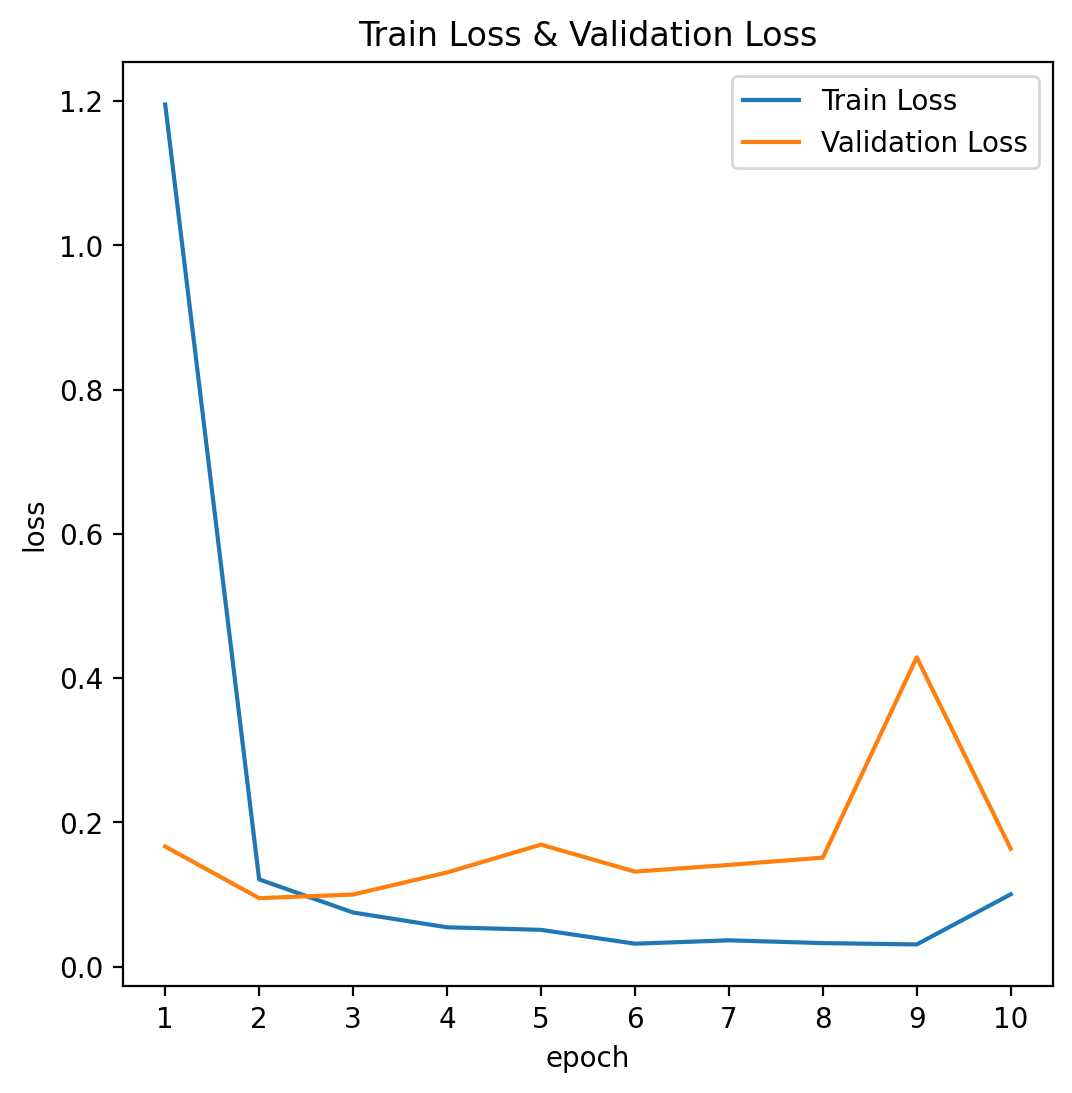

In [44]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(train_loss_history, label="Train Loss")
ax.plot(val_loss_history, label="Validation Loss")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Train Loss & Validation Loss")
ax.set_xticks(range(0, n_epochs))
ax.set_xticklabels(range(1, n_epochs + 1))
ax.legend()

plt.show()

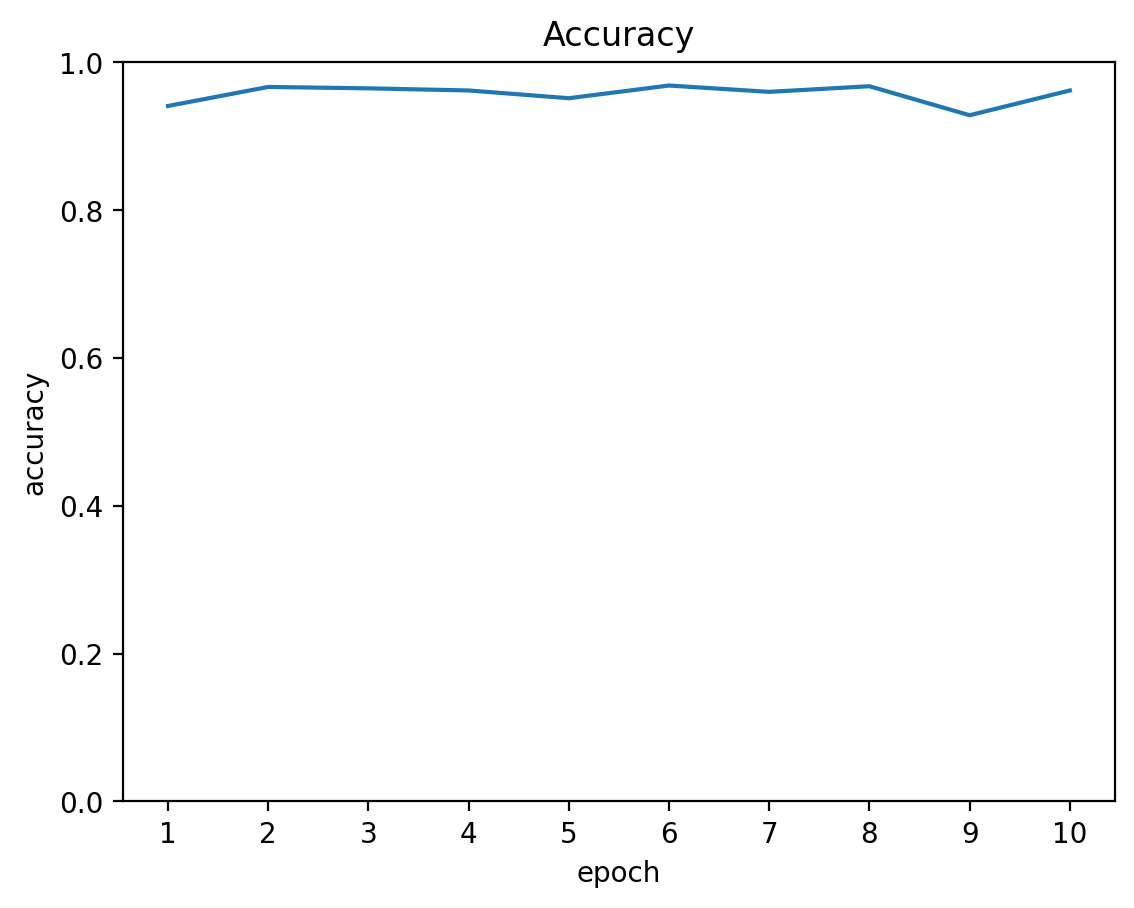

In [45]:
fig, ax = plt.subplots()

ax.plot(accuracy_history, label="Accuracy")

ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy")
ax.set_xticks(range(0, n_epochs))
ax.set_xticklabels(range(1, n_epochs + 1))
ax.set_ylim([0.0, 1.0])

plt.show()

## Test

In [46]:
model.eval()

total = 0
total_corrects = 0

with torch.no_grad():

    for images, labels in testloader:

        images, labels = images.to(device), labels.to(device)

        logits = model.forward(images)

        probabilities = logits.softmax(dim=1)

        top_probs, top_classes = probabilities.topk(k=1, dim=1)
        corrects = (top_classes == labels.view(*top_classes.shape))
        corrects = int(torch.sum(corrects).cpu().numpy())
        total_corrects += corrects

        total += labels.size(0)

In [47]:
total_corrects / total * 100.0

80.92948717948718

## Save the Model

In [ ]:
torch.save(model.state_dict(), "model_state_dict.pth")

In [ ]:
model_scripted = torch.jit.script(model) # export to TorchScript
model_scripted.save("model_scripted.pt") # save